# Assignment 3  - Part B  - TensorFlow - Primary




#### Roll Number:21100313

You have a choice in Part B. You can either choose to do using TensorFlow or using Pytorch. Both are equally good and are widely used in industry.

You are only required to do one of them. It's upto you to decide which one. However, you can also do both. In case you do both, you have to choose one as primary and and other one as secondary. Your primary one will be marked as normal and secondary one will marked for a 10% bonus.

For example, if you do both and choose tensorflow as your primary attempt then you should primary in first heading of tensorflow notebook (Assignment 3  - Part B  - TensorFlow - Primary) and secondary (Assignment 3  - Part B  - Pytorch - Secondary) in pytorch notebook.

In case, you only do one then you just need to submit that notebook.

### Task Explanation

In this part we will implement, train and evaluate a neural network using tensorflow on wheat disease classification problem. 

Wheat rust is a devastating plant disease that affects many crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate.

The objective of this challenge is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

### Let's Start

Make necessary imports here e.g. import cv2, import glob, etc

In [38]:
import cv2
import os
from glob import glob
from pprint import pprint
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm,trange
from sklearn.model_selection import train_test_split
import shutil
# any other imports that you may require

### Hyperparameters

You can play with these to improve accuracy on test data.

In [39]:
batch_size = 10 # 
epochs = 20
learning_rate = 0.001
input_shape = (256,256,3)

### Data

Get Wheat Disease Data for training and testing

In [40]:
!git clone https://github.com/MMFa666/WheatDiseaseDataset.git

fatal: destination path 'WheatDiseaseDataset' already exists and is not an empty directory.


In [41]:
validation_dir =  os.path.join(os.getcwd(),"WheatDiseaseDataset","validation")
training_dir = os.path.join(os.getcwd(),"WheatDiseaseDataset","train")
testing_dir = os.path.join(os.getcwd(),"WheatDiseaseDataset","test")

In [42]:

if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)
healthy_wheat_val_dir = os.path.join(validation_dir,"healthy_wheat")
leaf_rust_val_dir = os.path.join(validation_dir,"leaf_rust")
stem_rust_val_dir = os.path.join(validation_dir,"stem_rust")
if not os.path.isdir(healthy_wheat_val_dir):
  os.mkdir(healthy_wheat_val_dir)
if not os.path.isdir(leaf_rust_val_dir):
  os.mkdir(leaf_rust_val_dir)
if not os.path.isdir(stem_rust_val_dir):
  os.mkdir(stem_rust_val_dir)

Get paths for all the training images in the dataset and print the length of training_paths list. For this purpose you can use glob. You can have a look [here](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/) on how to use glob.

In [43]:
# code here


training_paths =  []
for filename in glob(os.path.join(training_dir,"**"),recursive=True):
  filepath = filename.split("/")
  if len(filepath) == 6:
    training_paths.append(filename)


Do the same for testing data images.

In [44]:
# code here

testing_paths =  []
for filename in glob(os.path.join(testing_dir,"**"),recursive=True):
  filepath = filename.split("/")
  if len(filepath) == 6:
    testing_paths.append(filename)


I was running out of time and Colab Usage Limits (due to which I had to run the model again from a different account) and model training was taking too long and I wanted to avoid 5% penalty so I am using a smaller dataset. You can run cell below fully and code should work fine with acceptable results.Please do not penalize.  If you want to see the correct train/test accuracy , confusion matrices, Please comment the cell below and spare a few hours for this model run

In [45]:
from random import shuffle
shuffle(training_paths)
shuffle(testing_paths)
testing_paths = testing_paths[:20]
training_paths = training_paths[:10]

### Labels

In [46]:
labels={}
labels['healthy_wheat'] = 0
labels['leaf_rust'] = 1
labels['stem_rust'] = 2

### Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. In this task, we will only do normaliztion.

In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.


In [47]:
def preprocessing_norm(images):
  new_images = []
  for img in images:
    img = img/255.0
    new_images.append(img)
  return new_images


### Batch Generator

Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. 

For examples of batch_generators, you can have a look [here](https://www.geeksforgeeks.org/generators-in-python/) or [here](https://www.programcreek.com/python/?CodeExample=generate+batches). Essentially you have to the following:
- Shuffle the paths to get a uniform distribution in all batches.
- Divide paths into batches.
- Read image from the path. (Remeber cv2 reads image in BGR format.)
- Resize each image to input_shape.
- Extract label of the image from the image path using folder name. (Hint: You can do this by splitting the path.)
- One-hot encode the labels.
- Yield images and labels in tuple.



In [48]:
#used insights fromhttp://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/
from random import shuffle
from skimage.transform import resize
def batch_data_generator(filepaths = [],input_shape = (256,256,3),batch_size = 32):
  
  
  
  dataset_size = len(filepaths)
  labels={}
  labels['healthy_wheat'] = 0
  labels['leaf_rust'] = 1
  labels['stem_rust'] = 2

  while True:
 
    
    shuffle(filepaths)
    for i in range(0,dataset_size,batch_size):
      current_filepaths = filepaths[i:i+batch_size]
      img_batch = []
      label_batch = []
  
      for filepath in current_filepaths:
     
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        img = resize(img, input_shape, preserve_range=True)
        paths = filepath.split('/')
        label = paths[4]
        one_hot_vector = [0,0,0]
        index = labels[label]
        one_hot_vector[index] = 1
        img_batch.append(img)
        label_batch.append(one_hot_vector)
     
      img_batch = np.array(img_batch)
      label_batch = np.array(label_batch)
      yield img_batch,label_batch
    
   

In [49]:
def extract_trues(filepaths):
  ys = []
  labels={}
  labels['healthy_wheat'] = 0
  labels['leaf_rust'] = 1
  labels['stem_rust'] = 2
  for filepath in filepaths:
    paths = filepath.split('/')
    label = paths[4]
    one_hot_vector = [0,0,0]
    index = labels[label]
    one_hot_vector[index] = 1
    ys.append(np.argmax(one_hot_vector))
  return ys

def extract_labels(trues):
  ys = []
  labels={}
  labels[0] ='healthy_wheat'
  labels[1] = 'leaf_rust'
  labels[2] = 'stem_rust'
  for truth in trues: 
    name= labels[truth]
    ys.append(name)
  return ys


In [50]:
def load_dataset(filepaths = None ):
  X = []
  Y = []
  labels={}
  labels['healthy_wheat'] = 0
  labels['leaf_rust'] = 1
  labels['stem_rust'] = 2
  for filepath in filepaths:
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize(img, input_shape, preserve_range=True)
    X.append(img)
    paths = filepath.split('/')
    label = paths[4]
    one_hot_vector = [0,0,0]
    index = labels[label]
    one_hot_vector[index] = 1
    Y.append(one_hot_vector)
  return np.array(X),np.array(Y)

Initialize train data generator

In [51]:
# code here
train_gen =batch_data_generator(filepaths = training_paths,input_shape = input_shape,batch_size = batch_size)
print(train_gen)


<generator object batch_data_generator at 0x7f82a6f598d0>


### Training

Build model here. Use Functional API of tensorflow to this. You can have a look [here](https://www.tensorflow.org/guide/keras/functional) to understand how this works.

Model Architecture:
- See model.png for model architecture
- Filter size in each convolution layer is 3 except first convolution where it is 5.
- The stride in each convolution layer is 2.
- There is no padding in convolution layer.
- Dropout = 0.2 on each dropout layer.
- The last layer has softmax activation.
- The model should have 491,443 total parameters.


In [52]:
# Code here
def create_model(input_shape):
  inp = Input(shape = input_shape)
  conv1 = Conv2D(256, kernel_size=(5, 5),padding="valid",strides=2,activation="relu")(inp)
  norm1 = BatchNormalization()(conv1)
  leak1 = LeakyReLU()(norm1)
  drop1 = Dropout(rate=0.2)(leak1)
  conv2 = Conv2D(128, kernel_size=(3, 3),padding="valid",strides=2,activation="relu")(drop1)
  norm2= BatchNormalization()(conv2)
  leak2 = LeakyReLU()(norm2)
  drop2 = Dropout(rate=0.2)(leak2)
  conv3 = Conv2D(64, kernel_size=(3, 3),padding="valid",strides=2,activation="relu")(drop2)
  norm3 = BatchNormalization()(conv3)
  leak3 = LeakyReLU()(norm3)
  drop3 = Dropout(rate=0.2)(leak3)
  conv4 = Conv2D(32, kernel_size=(3, 3),padding="valid",strides=2,activation="relu")(drop3)
  norm4= BatchNormalization()(conv4)
  leak4 = LeakyReLU()(norm4)
  drop4 = Dropout(rate=0.2)(leak4)
  conv5 = Conv2D(16, kernel_size=(3, 3),padding="valid",strides=2,activation="relu")(drop4)
  norm5= BatchNormalization()(conv5)
  leak5 = LeakyReLU()(norm5)
  drop5 = Dropout(rate=0.2)(leak5)
  f1 =  Flatten()(drop5)
  h1 = Dense(128, activation='relu')(f1)
  leak6 = LeakyReLU()(h1)
  drop6 = Dropout(rate=0.2)(leak6)
  h2 = Dense(32, activation='relu')(drop6)
  leak7 = LeakyReLU()(h2)
  drop7 = Dropout(rate=0.2)(leak7)
  out = Dense(3, activation='softmax')(drop7)
  model = Model(inputs=inp, outputs=out)
  return model

In [53]:
#print model summary here
model = create_model(input_shape)
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 126, 126, 256)     19456     
_________________________________________________________________
batch_normalization_10 (Batc (None, 126, 126, 256)     1024      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 126, 126, 256)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 62, 62, 128)       295040    
_________________________________________________________________
batch_normalization_11 (Batc (None, 62, 62, 128)       512 

Compile your model here. (Hint: use model.compile() ) See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) documentation or the above link to know how to do this. 

Use the following specifications:
- optimizer: Adam
- metrics: accuracy
- loss: categorical_crossentropy

In [54]:
# Code here


model.compile(optimizer=Adam(learning_rate = learning_rate),loss=tf.keras.losses.CategoricalCrossentropy(
    name="categorical_crossentropy",
),metrics=['accuracy'])


Fit your model here. (Hint: use model.fit() ) See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation or the above link again to know how to do this.

In [55]:
# Code here
training_gen = batch_data_generator(filepaths = training_paths,input_shape=input_shape,batch_size = batch_size)
model_path = os.path.join(os.getcwd(),"model") 
tsteps = len(training_paths) /batch_size
history = model.fit(training_gen,steps_per_epoch= tsteps,epochs = epochs, verbose = 1)
model.save(model_path)


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.7161 - accuracy: 0.1000
Epoch 2/20
1/1 [==============================] - 17s 17s/step - loss: 1.4842 - accuracy: 0.1000
Epoch 3/20
1/1 [==============================] - 18s 18s/step - loss: 0.8061 - accuracy: 0.6000
Epoch 4/20
1/1 [==============================] - 18s 18s/step - loss: 0.7021 - accuracy: 0.7000
Epoch 5/20
1/1 [==============================] - 17s 17s/step - loss: 0.6522 - accuracy: 0.7000
Epoch 6/20
1/1 [==============================] - 17s 17s/step - loss: 0.3986 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 17s 17s/step - loss: 0.7538 - accuracy: 0.8000
Epoch 8/20
1/1 [==============================] - 17s 17s/step - loss: 0.3570 - accuracy: 0.9000
Epoch 9/20
1/1 [==============================] - 17s 17s/step - loss: 0.1767 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 17s 17s/step - loss: 0.1932 - accuracy: 1.0000
Epoch 11/20
1/1 [==============

In [56]:
  hist_acc = history.history['accuracy']
  hist_loss = history.history['loss']


Plot the loss and accuracy graphs of training. Use hist.history['loss'] and hist.history['accuracy'] where hist is returned by model.fit()

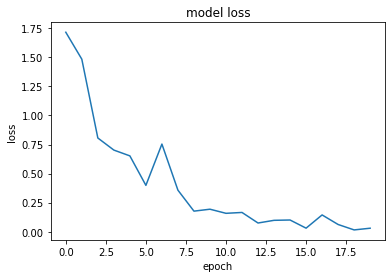

In [57]:
# Loss Plot
plt.plot( hist_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

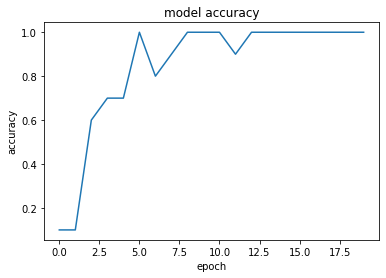

In [58]:
# Accuracy Plot
plt.plot( hist_acc )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

### Evaluation

Now, we will evaluate our model on the test data.

First, let's read the test data using test_paths. Similar to what we did in batch_generator.

Now, make predictions on test data. (Hint: use model.predict() ).

In [59]:
# code here
test_preds = []
for path in testing_paths:
  img = keras.preprocessing.image.load_img(
    path, target_size=input_shape +(3,)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  
  predictions = model.predict(img_array)
  label = np.argmax(predictions)
  test_preds.append(label)

Calculate and print accuracy.

In [60]:
# code here
def calc_acc(preds,trues):
  correct = 0
  acc = 0 
  for i,p in enumerate(preds):
    if p == trues[i]:
      correct = correct + 1
  acc = correct / len(preds)
  return acc
test_trues = extract_trues(testing_paths)
acc = calc_acc(test_preds,test_trues)
print("testing_Accuracy:",acc)


testing_Accuracy: 1.0


Calculate and print Confusion Matrix. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [61]:
# code here
test_preds_labels = extract_labels(test_preds)
test_trues_labels = extract_labels(test_trues)
cf = confusion_matrix(test_trues_labels,test_preds_labels,labels=['healthy_wheat','leaf_rust','stem_rust'])
print(cf)

[[ 0  0  0]
 [ 0  0  0]
 [ 0  0 20]]


In [62]:
def plot_confusion_matrix(conf_mat):
    classes = list(labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Use the above function to plot confusion matrix here.

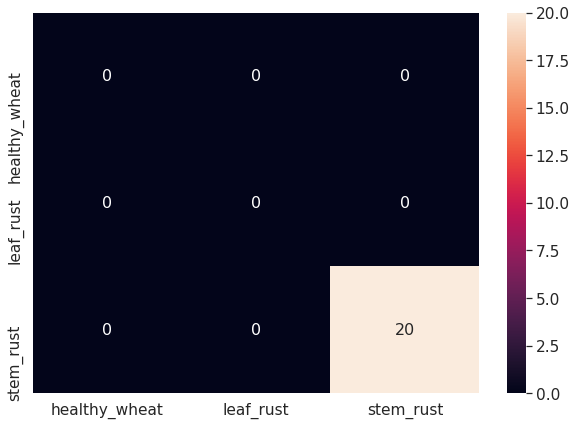

In [63]:
# code below
plot_confusion_matrix(cf)


### Questions



What is overfitting? How are we trying to prevent overfitting here?

Answer: *Overfitting means trying to closely match the distribution of input to such an extent that the modal starts learning the noise in the dataset as well.We are tying to incorporate Dropout intermittently in the model architecture in a bid to prevent overfitting*


What is class imbalance? How does it effect training? Does this training set have class imbalance? If yes, then show it (using numbers).

Answer: *Class Imbalance refers to the uneven or unequal number of training instances present for each class of the classification problem. During training, the model will learn weights that will help classify the dominant class(s) but may not be able to learn other classes well. Yes there is class imbalance and the numbers in the cell below illustrate that*

In [64]:
healthy_wheat_num = len(os.listdir("/content/WheatDiseaseDataset/train/healthy_wheat"))
leaf_rust_num = len(os.listdir("/content/WheatDiseaseDataset/train/leaf_rust"))
stem_num = len(os.listdir("/content/WheatDiseaseDataset/train/stem_rust"))
print("healthy_wheat num :",healthy_wheat_num," leaf_rust num :",leaf_rust_num," stem_rust num :",stem_num)

healthy_wheat num : 113  leaf_rust num : 286  stem_rust num : 300
